# Задание
Обучить нейронную сеть для распознавания действий человека по **видео на датасете KTH**

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'
warnings.filterwarnings('ignore')

In [2]:
import os
import time
from pathlib import Path
import glob
import random
import skvideo
import skvideo.io
import tensorflow as tf

# Load data. Preprocessing

In [3]:
# !wget http://www.nada.kth.se/cvap/actions/walking.zip
# !wget http://www.nada.kth.se/cvap/actions/jogging.zip
# !wget http://www.nada.kth.se/cvap/actions/running.zip
# !wget http://www.nada.kth.se/cvap/actions/boxing.zip
# !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
# !wget http://www.nada.kth.se/cvap/actions/handclapping.zip

In [4]:
vid_dir = os.path.join(Path(os.getcwd()), 'vid')

In [5]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(vid_dir, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))
print('*'*100)
print(f'Dataset len - {len(dataset)}')

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping
****************************************************************************************************
Dataset len - 599


In [32]:
SUBSET_LEN = 180
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]
test_dataset = dataset[-7:-4]
print('Subset samples:', len(dataset))

Subset samples: 180


In [7]:
max_vid_len = 0
min_vid_len = np.inf
for vid in dataset:
    videodata = skvideo.io.vread(vid[0])
    if videodata.shape[0] > max_vid_len:
        max_vid_len = videodata.shape[0]
    if videodata.shape[0] < min_vid_len:
        min_vid_len = videodata.shape[0]
print(f'Максимальная длина кадров- {max_vid_len}, минимальная - {min_vid_len}')

Максимальная длина кадров- 960, минимальная - 242


In [8]:
def cut_video(vid):
    vid = vid.astype(np.float32) / 255.
    mid = vid.shape[0] // 2
    slide = min_vid_len // 2
    start = mid - slide
    stop = mid + slide
    return vid[start:stop, ...]

videodata shape: (242, 120, 160, 3)


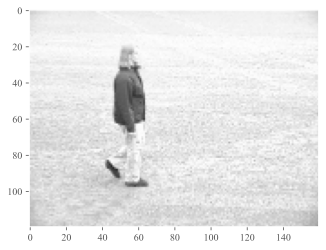

In [27]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = cut_video(videodata)
print('videodata shape:', videodata.shape)
plt.imshow(videodata[0, ...])
plt.grid(None)
plt.show()

**********

# Model build

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2),
                           padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2),
                           padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2),
                           padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(6, activation=None),
])

# Training

In [11]:
def dataset_prepare(idx):
    vid_list = []
    label_list = []
    for i in idx:
        videodata = cut_video(skvideo.io.vread(dataset[i][0]))
        videodata = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        vid_list.append(videodata)
        label_list.append(dataset[i][1])

    return np.array(vid_list), np.array(label_list)

In [12]:
NUM_EPOCHS = 40
LEARNING_RATE = 0.001
opt = optimizer=tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt)

writer = tf.summary.create_file_writer('logs/exptcv')

In [13]:
checkpoint_dir = 'training_att_checkpoints'

checkpoint = tf.train.Checkpoint(optimizer=opt,
                                 model=model)

In [14]:
global_step = 0
BATCH_SIZE = 3
verbose = 1
min_loss = 0.1
for ep in range(NUM_EPOCHS):
    
    start = time.time()
    total_loss = 0
    batch_ind = np.arange(SUBSET_LEN)
    np.random.shuffle(batch_ind)
    batch_ind = batch_ind.reshape((-1, BATCH_SIZE))
    
    for iter, batch in enumerate(batch_ind):
        x, y = dataset_prepare(batch)
        loss_value = model.train_on_batch(x, y)
        total_loss += loss_value
        if ((iter+1) % 20 == 0) and (verbose == 2):
            print(
                f'[{ep+1}/{NUM_EPOCHS}][{iter+1}/{len(batch_ind)}] Loss = {loss_value}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)
        global_step += 1
    if verbose >= 1:
        ep_loss = round(total_loss/len(batch_ind), 3)
        print(f'EPOCH_{ep+1} Loss: {ep_loss} ----> Time taken {round(time.time()-start)}')
    if ep_loss < min_loss:
        min_loss = ep_loss
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_", str(ep))
        checkpoint.save(file_prefix=checkpoint_prefix)
        if min_loss < 0.03:
            break

EPOCH_1 Loss: 1.66 ----> Time taken 113
EPOCH_2 Loss: 1.145 ----> Time taken 107
EPOCH_3 Loss: 0.915 ----> Time taken 107
EPOCH_4 Loss: 0.747 ----> Time taken 107
EPOCH_5 Loss: 0.677 ----> Time taken 107
EPOCH_6 Loss: 0.511 ----> Time taken 107
EPOCH_7 Loss: 0.593 ----> Time taken 107
EPOCH_8 Loss: 0.535 ----> Time taken 107
EPOCH_9 Loss: 0.39 ----> Time taken 107
EPOCH_10 Loss: 0.43 ----> Time taken 107
EPOCH_11 Loss: 0.386 ----> Time taken 107
EPOCH_12 Loss: 0.3 ----> Time taken 106
EPOCH_13 Loss: 0.349 ----> Time taken 107
EPOCH_14 Loss: 0.243 ----> Time taken 107
EPOCH_15 Loss: 0.239 ----> Time taken 106
EPOCH_16 Loss: 0.25 ----> Time taken 108
EPOCH_17 Loss: 0.331 ----> Time taken 106
EPOCH_18 Loss: 0.193 ----> Time taken 107
EPOCH_19 Loss: 0.28 ----> Time taken 106
EPOCH_20 Loss: 0.215 ----> Time taken 107
EPOCH_21 Loss: 0.179 ----> Time taken 107
EPOCH_22 Loss: 0.159 ----> Time taken 109
EPOCH_23 Loss: 0.124 ----> Time taken 106
EPOCH_24 Loss: 0.1 ----> Time taken 107
EPOCH_25 L

In [15]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [34]:
%load_ext tensorboard
%tensorboard --logdir logs

# Test result

In [17]:
def show_predictions(test_vid, frame):    
    videodata = skvideo.io.vread(test_vid[0])
    videodata = cut_video(videodata)
    plt.subplot()
    plt.grid(False)
    plt.imshow(videodata[0, ...])
    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
    out = model(motion[None, ...])[0]
    cls_pred = np.argmax(out.numpy())

    print('True class:', classes[test_vid[1]])
    print('Predicted class:', classes[cls_pred])
    plt.show()

True class: handclapping
Predicted class: handclapping


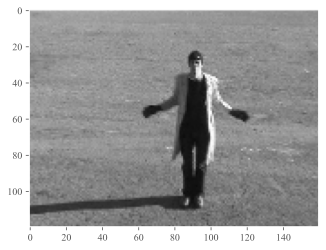

In [33]:
show_predictions(test_dataset[0], 100)

True class: jogging
Predicted class: jogging


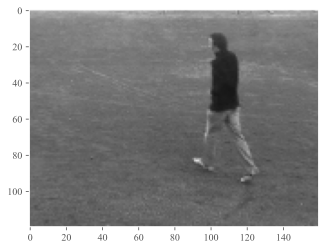

In [19]:
show_predictions(test_dataset[1], 0)

True class: boxing
Predicted class: boxing


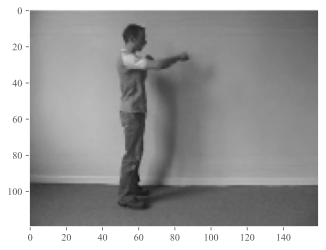

In [20]:
show_predictions(test_dataset[2], 0)